# Image Captioning with Ludwig

In this notebook, we will use ludwig to train an image captioning system. We be using the Flickr 8k dataset which contains eight thousand images with 5 human generated captions per image. 

Our model will consist of a VGG16 pretrained image encoder, a vector encoder, and a lstm text decoder. 

First, lets install ludwig and import all the modules we will need

In [1]:
!pip install --quiet ludwig

     |████████████████████████████████| 235kB 8.1MB/s 
     |████████████████████████████████| 9.5MB 11.7MB/s 
     |████████████████████████████████| 706kB 58.0MB/s 


In [ ]:
import ludwig
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from ludwig.api import LudwigModel
import logging
from tqdm import tqdm

Let's load the dataset which can be done in two lines using Ludwig's datasets module. This gives us three dataframes for our training, validation, and test sets

In [ ]:
from ludwig.datasets import flickr8k

In [3]:
train, vali, test = flickr8k.load(split=True)

In [4]:
train.head()

,image_path,caption0,caption1,caption2,caption3,caption4,split
0,/root/.ludwig_cache/flickr8k_1.0/raw/Flicker8k...,A black dog is running after a white dog in th...,Black dog chasing brown dog through snow,Two dogs chase each other across the snowy ground,Two dogs play together in the snow,Two dogs running through a low lying body of w...,0
1,/root/.ludwig_cache/flickr8k_1.0/raw/Flicker8k...,A little baby plays croquet,A little girl plays croquet next to a truck,The child is playing croquette by the truck,The kid is in front of a car with a put and a ...,The little boy is playing with a croquet hamme...,0
2,/root/.ludwig_cache/flickr8k_1.0/raw/Flicker8k...,A brown dog in the snow has something hot pink...,A brown dog in the snow holding a pink hat,A brown dog is holding a pink shirt in the snow,A dog is carrying something pink in its mouth ...,A dog with something pink in its mouth is look...,0
3,/root/.ludwig_cache/flickr8k_1.0/raw/Flicker8k...,A brown dog is running along a beach,A brown dog wearing a black collar running acr...,A dog walks on the sand near the water,Brown dog running on the beach,The large brown dog is running on the beach by...,0
4,/root/.ludwig_cache/flickr8k_1.0/raw/Flicker8k...,A black and white dog with a red Frisbee stand...,A dog drops a red disc on a beach,A dog with a red Frisbee flying in the air,Dog catching a red Frisbee,The black dog is dropping a red disc on a beach,0


We will now load the pre-trained VGG16 model from keras to help us process our images. Since our dataset is relatively small, it would be relatively ineffective to train our own image encoder from scratch

In [5]:
from keras.applications import VGG16

modelvgg = VGG16(include_top=True,weights='imagenet')

553467904/553467096 [==============================] - 4s 0us/step


In [6]:
from keras import models
modelvgg = models.Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-2].output)
## show the deep learning model
modelvgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Here we will define a function that will use the pretrained model to extract features from the images in our dataset. As seen in the model summary, every image will be converted into a size-4096 vector encoding.

In [7]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

In [8]:
def extract_features(dataset, model):
    features = []
    for path in tqdm(dataset['image_path']):
        image = load_img(path, target_size=(224,224,3))
        image = img_to_array(image)
        nimage = preprocess_input(image)
        y_pred = model.predict(nimage.reshape( (1,) + nimage.shape[:3])).flatten()
        y_pred = np.array2string(y_pred, separator=" ")
        features.append(y_pred[1:-1])
    dataset['features'] = features

We will be using Ludwig's vector encoders later on to process the features extracted by VGG16. These encoders require inputs to be strings of whitespace seperated values, so we will be converting the numpy vectors to strings using the `np.array2string()` method.

Note that we need to set numpy's print threshold to np.inf so that the the strings will not be truncated

In [9]:
# set print threshold so that strings don't get truncated
np.set_printoptions(threshold=np.inf)

In [10]:
extract_features(train, modelvgg)

100%|██████████| 6000/6000 [08:10<00:00, 12.22it/s]


In [11]:
train.head()

,image_path,caption0,caption1,caption2,caption3,caption4,split,features
0,/root/.ludwig_cache/flickr8k_1.0/raw/Flicker8k...,A black dog is running after a white dog in th...,Black dog chasing brown dog through snow,Two dogs chase each other across the snowy ground,Two dogs play together in the snow,Two dogs running through a low lying body of w...,0,0.00000000e+00 0.00000000e+00 1.70414662e+00 0...
1,/root/.ludwig_cache/flickr8k_1.0/raw/Flicker8k...,A little baby plays croquet,A little girl plays croquet next to a truck,The child is playing croquette by the truck,The kid is in front of a car with a put and a ...,The little boy is playing with a croquet hamme...,0,0.00000000e+00 0.00000000e+00 1.55578876e+00 3...
2,/root/.ludwig_cache/flickr8k_1.0/raw/Flicker8k...,A brown dog in the snow has something hot pink...,A brown dog in the snow holding a pink hat,A brown dog is holding a pink shirt in the snow,A dog is carrying something pink in its mouth ...,A dog with something pink in its mouth is look...,0,4.33650494e-01 0.00000000e+00 6.29287124e-01 0...
3,/root/.ludwig_cache/flickr8k_1.0/raw/Flicker8k...,A brown dog is running along a beach,A brown dog wearing a black collar running acr...,A dog walks on the sand near the water,Brown dog running on the beach,The large brown dog is running on the beach by...,0,1.37257230e+00 0.00000000e+00 0.00000000e+00 0...
4,/root/.ludwig_cache/flickr8k_1.0/raw/Flicker8k...,A black and white dog with a red Frisbee stand...,A dog drops a red disc on a beach,A dog with a red Frisbee flying in the air,Dog catching a red Frisbee,The black dog is dropping a red disc on a beach,0,0.00000000e+00 0.00000000e+00 0.00000000e+00 0...


In [12]:
extract_features(vali, modelvgg)

100%|██████████| 1000/1000 [01:20<00:00, 12.39it/s]


In [13]:
vali.head()

,image_path,caption0,caption1,caption2,caption3,caption4,split,features
7000,/root/.ludwig_cache/flickr8k_1.0/raw/Flicker8k...,The dogs are in the snow in front of a fence,The dogs play on the snow,Two brown dogs playfully fight in the snow,Two brown dogs wrestle in the snow,Two dogs playing in the snow,2,0.00000000e+00 0.00000000e+00 1.16819048e+00 0...
7001,/root/.ludwig_cache/flickr8k_1.0/raw/Flicker8k...,a brown and white dog swimming towards some in...,A dog in a swimming pool swims toward sombody ...,A dog swims in a pool near a person,Small dog is paddling through the water in a pool,The small brown and white dog is in the pool,2,5.43367386e-01 0.00000000e+00 3.72562504e+00 0...
7002,/root/.ludwig_cache/flickr8k_1.0/raw/Flicker8k...,A man and a woman in festive costumes dancing,A man and a woman with feathers on her head dance,A man and a woman wearing decorative costumes ...,one performer wearing a feathered headdress da...,Two people are dancing with drums on the right...,2,0.00000000e+00 0.00000000e+00 0.00000000e+00 0...
7003,/root/.ludwig_cache/flickr8k_1.0/raw/Flicker8k...,A couple of people sit outdoors at a table wit...,Three people are sitting at an outside picnic ...,Three people sit at an outdoor cafe,Three people sit at an outdoor table in front ...,Three people sit at a picnic table outside of ...,2,0.00000000e+00 1.16200352e+00 0.00000000e+00 0...
7004,/root/.ludwig_cache/flickr8k_1.0/raw/Flicker8k...,A man is wearing a Sooners red football shirt ...,A Oklahoma Sooners football player wearing his...,A Sooners football player weas the number 28 a...,Guy in red and white football uniform,The American footballer is wearing a red and w...,2,0.00000000e+00 6.06312752e-01 6.77055717e-02 0...


In [14]:
extract_features(test, modelvgg)

100%|██████████| 1000/1000 [01:20<00:00, 12.38it/s]


In [15]:
test.head()

,image_path,caption0,caption1,caption2,caption3,caption4,split,features
6000,/root/.ludwig_cache/flickr8k_1.0/raw/Flicker8k...,the boy laying face down on a skateboard is be...,Two girls play on a skateboard in a courtyard,Two people play on a long skateboard,Two small children in red shirts playing on a ...,two young children on a skateboard going acros...,1,1.11303127e+00 0.00000000e+00 5.72722101e+00 0...
6001,/root/.ludwig_cache/flickr8k_1.0/raw/Flicker8k...,a boy in a blue top is jumping off some rocks ...,A boy jumps off a tan rock,A boy jumps up in a field in the woods,A young boy jumps off a rock in the forest,Child in blue and grey shirt jumping off hill ...,1,2.81965780e+00 0.00000000e+00 0.00000000e+00 0...
6002,/root/.ludwig_cache/flickr8k_1.0/raw/Flicker8k...,A lady walking her dog through an obstacle cou...,A small tan and white dog and trainer running ...,A woman is guiding a brown dog around an obsta...,A woman with a hat is leading a small dog thro...,The woman is leading a dog through an obstacle...,1,9.47794318e-02 1.11764956e+00 0.00000000e+00 8...
6003,/root/.ludwig_cache/flickr8k_1.0/raw/Flicker8k...,a big black dog jumps in the air to catch the ...,A dog looks at another dog catching a ball in ...,A white dog is watching a black dog jump on a ...,A white dog watching a black dog in the air,Two dogs playing with a tennis ball in the yard,1,1.09201825e+00 2.42229056e+00 1.90147555e+00 0...
6004,/root/.ludwig_cache/flickr8k_1.0/raw/Flicker8k...,two woman climbing rocks around the ocean,Two women are climbing over rocks near to the ...,Two women climb on top of rocks in front of th...,Two women in bathing suit on large rocks at th...,Two women in bathing suits climb rock piles by...,1,1.46628594e+00 0.00000000e+00 0.00000000e+00 0...


There seems to be a threading error if we use tensorflow outside of ludwig, so this code block helps us reset the tensorflow context to prevent that error during model training. (Referenced from [Stack Overflow](https://stackoverflow.com/questions/59616436/how-to-reset-initialization-in-tensorflow-2))

In [16]:
from tensorflow.python.eager import context

context._context = None
context._create_context()

We define our configuration to use a dense vector encoder and a lstm text decoder. Other hyperparameters such as encoder size, batch size, and learning rate are also specifed.

In [ ]:
config = {
    "input_features": [
        {
            "name": "features",
            "type": "vector",
            "encoder": "dense",
            "layers": [
                {
                    "fc_size": 2000
                }
            ]
        }
    ],
    "output_features": [
        {            
            "name": "caption0",
            "type": "text",
            "level": "word",
            "decoder": "generator",
            "cell_type": "lstm"
        }
    ],
    "training": {
        "batch_size": 16,
        "learning_rate": 0.0001
    }
}

Initialize and train a LudwigModel

In [17]:
model = LudwigModel(config, logging_level=logging.INFO)
train_stats, _, _ = model.train(
    training_set=train,
    validation_set=vali,
    test_set=test,
    experiment_name='image_captioning',
    model_name='example',
    skip_save_model=True
)

Experiment name: image_captioning
Model name: example
Output directory: results/image_captioning_example


ludwig_version: '0.3.2'
command: ('/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py -f '
 '/root/.local/share/jupyter/runtime/kernel-3b7acd09-cae6-46c0-8ab0-252d6f0b868a.json')
random_seed: 42
data_format: "<class 'pandas.core.frame.DataFrame'>"
config: {   'combiner': {'type': 'concat'},
    'input_features': [   {   'column': 'features',
                              'encoder': 'dense',
                              'layers': [{'fc_size': 2000}],
                              'name': 'features',
                              'preprocessing': {},
                              'proc_column': 'features_mZFLky',
                              'tied': None,
                              'type': 'vector'}],
    'output_features': [   {   'cell_type': 'lstm',
                               'column': 'caption0',
                               'decoder': 'generator',
         

Plot the learning curves

In [18]:
import json
with open('/content/results/image_captioning_example/training_statistics.json', 'r') as f:
    train_stats = json.load(f)

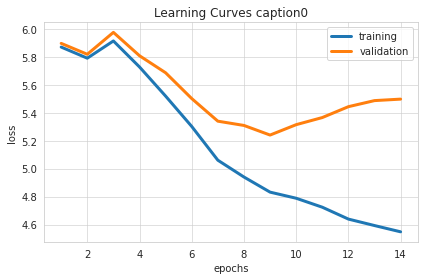

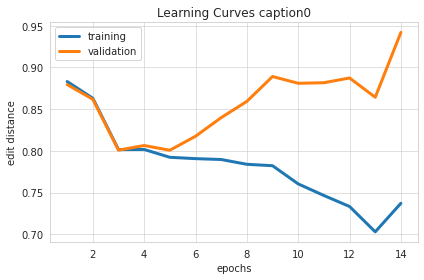

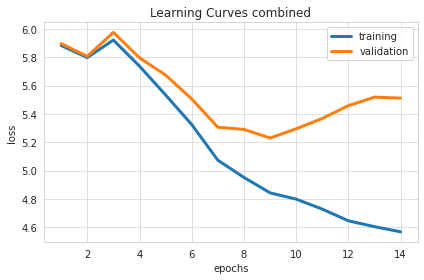

In [20]:
from ludwig.visualize import learning_curves
learning_curves(
    train_stats_per_model = train_stats, 
    output_feature_name = None,
    output_directory='./visualizations',
    file_format='png'
)

Make predictions over the test set

In [21]:
predictions, _ = model.predict(dataset=test)

Prediction: 100%|██████████| 8/8 [00:00<00:00,  8.01it/s]


In [23]:
predictions

,caption0_predictions,caption0_last_predictions,caption0_probability
0,"[a, boy, in, a, red, shirt, on, a, red, shirt,...",red,4.362111e-12
1,"[a, man, in, a, red, shirt, is, on, a, rock, <...",rock,1.101030e-08
2,"[a, man, and, a, white, dog, is, running, on, ...",field,1.472331e-09
3,"[a, dog, and, a, dog, in, a, field, <PAD>, <PA...",field,1.037231e-06
4,"[a, man, in, a, red, shirt, is, is, is, on, th...",rock,1.633844e-14
...,...,...,...
995,"[a, man, in, a, bike, <PAD>, <PAD>, <PAD>, <PA...",bike,3.094914e-19
996,"[a, dog, and, a, dog, on, the, snow, <PAD>, <P...",snow,2.108629e-21
997,"[a, man, in, a, snow, <PAD>, <PAD>, <PAD>, <PA...",snow,2.215584e-21
998,"[a, man, in, a, woman, is, standing, on, a, st...",street,1.195243e-24


In [57]:
frames = [test, predictions]
test = test.reset_index(drop=True)
predictions = predictions.reset_index(drop=True)
test_pred = pd.concat(frames, axis=1)

In [58]:
test_pred

,image_path,caption0,caption1,caption2,caption3,caption4,split,features,predictions,caption0_predictions,caption0_last_predictions,caption0_probability
0,/root/.ludwig_cache/flickr8k_1.0/raw/Flicker8k_Dataset/2090545563_a4e66ec76b.jpg,the boy laying face down on a skateboard is being pushed along the ground by another boy,Two girls play on a skateboard in a courtyard,Two people play on a long skateboard,Two small children in red shirts playing on a skateboard,two young children on a skateboard going across a sidewalk,1,1.11303127e+00 0.00000000e+00 5.72722101e+00 0.00000000e+00\n 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.53807354e+00\n 0.00000000e+00 0.00000...,NaN,"[a, boy, in, a, red, shirt, on, a, red, shirt, on, a, red, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PA...",red,4.362111e-12
1,/root/.ludwig_cache/flickr8k_1.0/raw/Flicker8k_Dataset/3393035454_2d2370ffd4.jpg,a boy in a blue top is jumping off some rocks in the woods,A boy jumps off a tan rock,A boy jumps up in a field in the woods,A young boy jumps off a rock in the forest,Child in blue and grey shirt jumping off hill in the woods,1,2.81965780e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00\n 2.44392443e+00 0.00000000e+00 0.00000000e+00 1.44735265e+00\n 9.93075132e-01 0.00000...,NaN,"[a, man, in, a, red, shirt, is, on, a, rock, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PA...",rock,1.101030e-08
2,/root/.ludwig_cache/flickr8k_1.0/raw/Flicker8k_Dataset/3695064885_a6922f06b2.jpg,"A lady walking her dog through an obstacle course , while other people are in the background",A small tan and white dog and trainer running an obstacle course,A woman is guiding a brown dog around an obstacle course,A woman with a hat is leading a small dog through an obstacle course,The woman is leading a dog through an obstacle course,1,9.47794318e-02 1.11764956e+00 0.00000000e+00 8.80976021e-02\n 0.00000000e+00 0.00000000e+00 5.64998746e-01 1.93291306e+00\n 0.00000000e+00 3.20804...,NaN,"[a, man, and, a, white, dog, is, running, on, a, field, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>,...",field,1.472331e-09
3,/root/.ludwig_cache/flickr8k_1.0/raw/Flicker8k_Dataset/1679557684_50a206e4a9.jpg,a big black dog jumps in the air to catch the tennis ball in his mouth,A dog looks at another dog catching a ball in the air,A white dog is watching a black dog jump on a lawn next to a pile of large rocks,A white dog watching a black dog in the air,Two dogs playing with a tennis ball in the yard,1,1.09201825e+00 2.42229056e+00 1.90147555e+00 0.00000000e+00\n 5.59761572e+00 4.04032439e-01 2.45941567e+00 0.00000000e+00\n 0.00000000e+00 0.00000...,NaN,"[a, dog, and, a, dog, in, a, field, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>...",field,1.037231e-06
4,/root/.ludwig_cache/flickr8k_1.0/raw/Flicker8k_Dataset/3582685410_05315a15b8.jpg,two woman climbing rocks around the ocean,Two women are climbing over rocks near to the ocean,Two women climb on top of rocks in front of the ocean,Two women in bathing suit on large rocks at the ocean,Two women in bathing suits climb rock piles by the ocean,1,1.46628594e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00\n 4.58720398e+00 0.00000000e+00 0.00000000e+00 2.78020501e+00\n 0.00000000e+00 7.86318...,NaN,"[a, man, in, a, red, shirt, is, is, is, on, the, rock, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, ...",rock,1.633844e-14
...,...,...,...,...,...,...,...,...,...,...,...,...
995,/root/.ludwig_cache/flickr8k_1.0/raw/Flicker8k_Dataset/3487378989_c051d2715b.jpg,a lone bicyclist jumping on his bike in front of a graffitied wall,A man doing tricks on a bike,A man grabs the spokes of his bicycle while he jumps,A man on a bicycle in jeans is doing an air track along a dirt track with graffiti nearby,A man performs

Let's take a look at some of the captions that our model generated for the test set

In [ ]:
from PIL import Image
pd.set_option('display.max_colwidth',150)

In [99]:
def view_caption(index):
    arr = test_pred.iloc[index]["caption0_predictions"]
    for word in arr:
        if word == '<PAD>':
            print(" ")
            break
        else:
            print(word, end=' ')

Here are examples of good predictions

a black dog in the water 

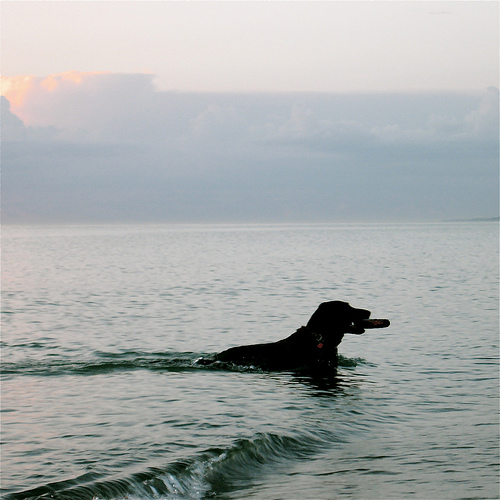

In [80]:
view_caption(908)
Image.open(test_pred.iloc[908]["image_path"])
# correctly identified the dog and the environment, relatively simple sentence structure

a brown dog is running in a grass 

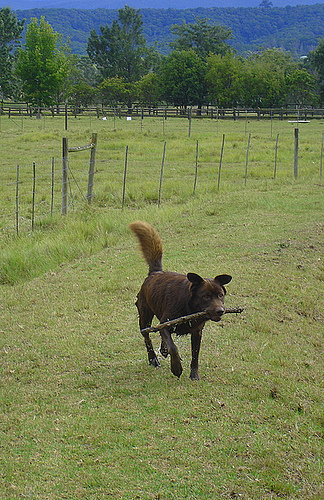

In [93]:
view_caption(50)
Image.open(test_pred.iloc[50]["image_path"])
# correctly identified the dog and the environment, relatively simple sentence structure

a group of people are on the beach 

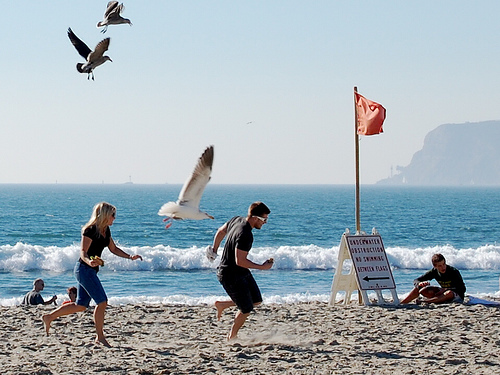

In [96]:
view_caption(55)
Image.open(test_pred.iloc[55]["image_path"])
# correct grammar, environment, and characterization of the people

a brown dog is running on a snow  


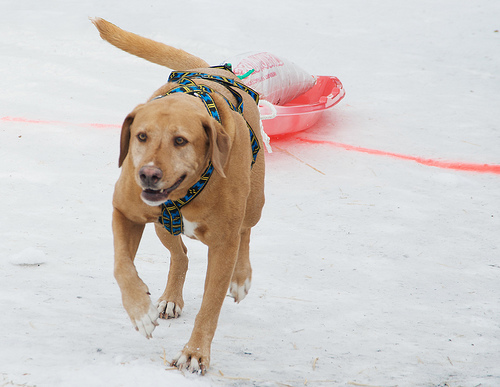

In [160]:
view_caption(291)
Image.open(test_pred.iloc[291]["image_path"])
# more dogs !!! 

Anecdotally, our model seems pretty good at identifying dogs and environments. 

However, here are examples of bad predictions.

a boy in a red shirt in a beach  


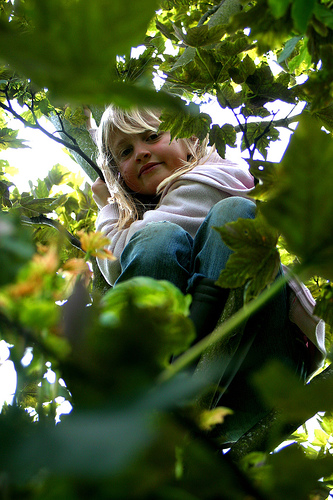

In [113]:
view_caption(738)
Image.open(test_pred.iloc[738]["image_path"])
# wrong gender, wrong colors, wrong setting

a man in a red shirt is and a white shirt is and a white shirt is is is on the water  


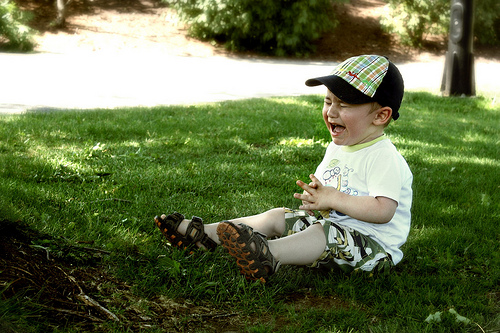

In [152]:
view_caption(262)
Image.open(test_pred.iloc[262]["image_path"])
# gibberish that's unrelated to the image

a man is is on a skateboard on a skateboard  


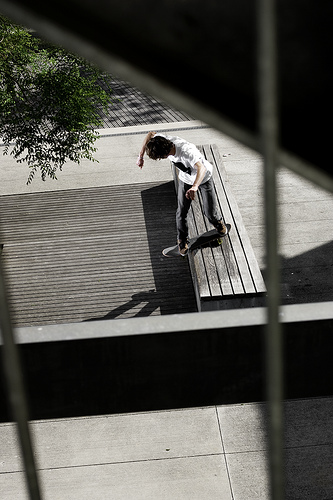

In [156]:
view_caption(309)
Image.open(test_pred.iloc[309]["image_path"])
# incorrect grammar

a man in a woman in a red shirt and a red shirt and a black and and black and and a black and and a black and  


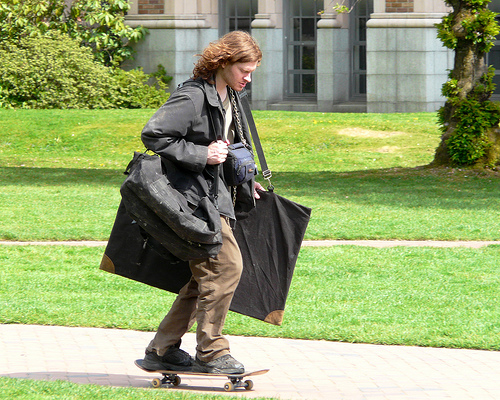

In [146]:
view_caption(873)
Image.open(test_pred.iloc[873]["image_path"])
# more gibberish

Finally, here is an entire list of all the captions generated by our model

In [153]:
for index in range(1000):
    arr = test_pred.iloc[index]["caption0_predictions"]
    caption = ""
    for word in arr:
        if word == '<PAD>':
            print(index, caption)
            break
        else:
            caption = caption + word + " "

0 a boy in a red shirt on a red shirt on a red 
1 a man in a red shirt is on a rock 
2 a man and a white dog is running on a field 
3 a dog and a dog in a field 
4 a man in a red shirt is is is on the rock 
5 a boy in the water 
6 people people are are are in the street 
7 a boy in a red shirt and a field 
8 a boy in a red shirt is on a skateboard 
9 a man in a red shirt is sitting on a blue shirt and a woman 
10 a boy in the water 
11 a man in a ball 
12 a black dog and a dog in a snow 
13 a boy in a red shirt is is on the water 
14 a man in a skateboard on a skateboard 
15 a boy in a skateboard in a pool 
16 a man in a woman in a red shirt 
17 a black dog and a dog in the water 
18 a man in the rock 
19 a man in a woman is standing with a woman and a woman and her and and a camera 
20 a brown dog is running in a grass 
21 a man in a woman is and a woman and a camera 
22 a man is on a skateboard on a skateboard 
24 a girl in a red shirt and a woman and a woman and a woman and a black 